In [7]:
import subprocess, shutil, glob, os, pandas as pd, matplotlib.pyplot as plt, time

NUM_RUNS   = 10
RUN_SCRIPT = "./run.sh"

def run_benchmark(idx: int):
    subprocess.run(["bash", RUN_SCRIPT], check=True)
    shutil.move("cold_results.csv", f"cold_results_{idx}")
    shutil.move("warm_results.csv", f"warm_results_{idx}")

for i in range(NUM_RUNS):
    run_benchmark(i)

Running benchmark to generate profile data...
CompileCommand: DumpReplay WordCountBenchmark.wordCount bool DumpReplay = true
# Compiler replay data is saved as: replay_pid47913_compid97.log
# Compiler replay data is saved as: replay_pid47913_compid208.log
# Compiler replay data is saved as: replay_pid47913_compid213.log
# Compiler replay data is saved as: replay_pid47913_compid217.log
Ran 2,000 invocations
Average: 583.7 µs | p95: 663 µs
Selecting largest replay file...
Original replay: replay_pid47913_compid217.log
Stripped replay saved as: replay_pid47913_compid217_nocompile.log
Running benchmark with no profile injection...
Ran 2,000 invocations
Average: 522.4 µs | p95: 568 µs
Running benchmark with profile injection (no forced compile)...
ProfileInjection: Starting profile injection
Resolving klass jdk/internal/reflect/Reflection at 153
Resolving klass java/util/Objects at 199
Resolving klass jdk/internal/loader/BootLoader at 227
Resolving klass jdk/internal/reflect/ReflectionFacto

In [8]:
# Load every captured CSV
cold_frames = [pd.read_csv(f) for f in sorted(glob.glob("cold_results_*"))]
warm_frames = [pd.read_csv(f) for f in sorted(glob.glob("warm_results_*"))]

assert cold_frames and warm_frames, "No results found – did run.sh succeed?"

# Average per‑invocation index
cold_avg = (
    pd.concat(cold_frames)
      .groupby("invocation", as_index=False)["time_us"]
      .mean()
      .rename(columns={"time_us": "cold_avg"})
)

warm_avg = (
    pd.concat(warm_frames)
      .groupby("invocation", as_index=False)["time_us"]
      .mean()
      .rename(columns={"time_us": "warm_avg"})
)

merged = cold_avg.merge(warm_avg, on="invocation")
merged.head()


,invocation,cold_avg,warm_avg
0,1,4604.0,4515.2
1,2,2613.6,692.5
2,3,699.7,614.0
3,4,697.8,1843.1
4,5,679.6,715.6


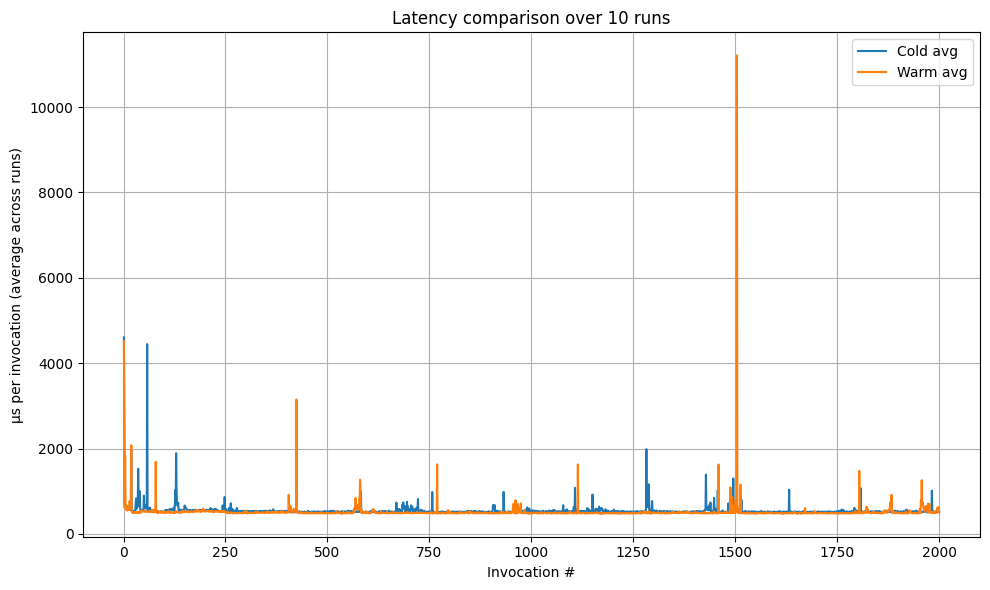

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(merged["invocation"], merged["cold_avg"], label="Cold avg")
plt.plot(merged["invocation"], merged["warm_avg"], label="Warm avg")
plt.xlabel("Invocation #")
plt.ylabel("μs per invocation (average across runs)")
plt.title(f"Latency comparison over {NUM_RUNS} runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# --- summary statistics --------------------------------------------------
def describe(series, label):
    print(f"\n{label}:")
    print(f"  • overall mean     : {series.mean():8.1f} µs")
    print(f"  • overall median   : {series.median():8.1f} µs")
    print(f"  • overall p95      : {series.quantile(0.95):8.1f} µs")

# Define the “plateau” as the last 20 % of invocations
plateau_start = int(0.8 * merged["invocation"].max())
plateau = merged[merged["invocation"] >= plateau_start]

cold_plateau_mean = plateau["cold_avg"].mean()
warm_plateau_mean = plateau["warm_avg"].mean()
speedup = (cold_plateau_mean - warm_plateau_mean) / cold_plateau_mean * 100

describe(merged["cold_avg"], "Cold run")
describe(merged["warm_avg"], "Warm run")

print(f"\nPlateau window (invocation ≥ {plateau_start}):")
print(f"  • cold mean  : {cold_plateau_mean:.1f} µs")
print(f"  • warm mean  : {warm_plateau_mean:.1f} µs")
print(f"  • warm faster by : {speedup:.2f}%")



Cold run:
  • overall mean     :    545.0 µs
  • overall median   :    522.2 µs
  • overall p95      :    608.0 µs

Warm run:
  • overall mean     :    517.6 µs
  • overall median   :    492.3 µs
  • overall p95      :    562.9 µs

Plateau window (invocation ≥ 1600):
  • cold mean  : 523.4 µs
  • warm mean  : 510.5 µs
  • warm faster by : 2.46%


In [12]:
rm -rf *.csv *.log cold_results* warm_results*